In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
n_samples=50000
n_features=20
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=5, n_redundant=2, n_repeated=0, n_classes=2,\
                           n_clusters_per_class=2, weights=[0.9,0.1], flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0,\
                           scale=1.0, shuffle=True, random_state=None)
y=np.array(y)
X=np.array(X)
y=np.reshape(y,(n_samples, 1))
X=np.reshape(X, (n_samples, n_features))
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)


In [2]:
y

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [3]:
#custom scoring function sklearn
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
def lift_index(y, probabilities):
    #rearrange probabilities and y in descending order
    probabilities = probabilities.ravel()
    combine = list(zip(y, probabilities))
    dtype = [('data', int), ('prob', float)]
    combine = np.array(combine,dtype=dtype)
    combine = np.sort(combine, order='prob') #sort according to probabilities
    ordered = np.sort(probabilities) #sort probabilities
    #divide into deciles
    deciles = pd.qcut(ordered, 10, duplicates='drop', labels=False) #creates array of digits from 1 to 10
    #sum of positive in each decile-if negative then zero and doesn't get taken into account
    sum_deciles = sum([((val+1)/10)*combine[num][0] for num, val in enumerate(deciles)])
    return sum_deciles/sum(y)
lift_index_score = make_scorer(lift_index, greater_is_better=True, needs_proba=True )



C:\Users\Snir\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Snir\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.noise import AlphaDropout
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.initializers import lecun_uniform
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

from keras import backend as K
from keras import callbacks
from keras import layers
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.externals import joblib

def construct_model(layers=[50,50], activation='relu', b_init='random_uniform', k_init='random_uniform', dropout=.0,\
                    a_dropout=.0, optimizer='sgd', loss='binary_crossentropy', metrics='roc_auc_score',input_dim=20, output_dim=1, model_name='most'):
    """
    Helper to construct a Keras model based on dict of specs and input size

    Parameters
    ----------
    model_spec: dict
        Dict containing keys: arch, activation, dropout, optimizer, loss,
            w_reg, metrics
    input_dim: int
        Size of input dimension
    output_dim: int
        Size of input dimension

    Returns
    -------
    model: Compiled keras.models.Sequential

    """

    model = Sequential()

    for li, layer_size in enumerate(layers):
        # For input layer, add input dimension
        if li == 0:
            temp_input_dim = input_dim
            model.add(Dense(layer_size,
                            input_dim=temp_input_dim,
                            activation=activation,
                            bias_initializer=b_init,
                            kernel_initializer=k_init,
                            name='Input'))
        elif li < len(layers)-1:
            model.add(Dense(layer_size,
                            activation=activation,
                            bias_initializer=b_init,
                            kernel_initializer=k_init,
                            name='Layer_%i' % li))
        elif li == len(layers)-1:
            model.add(Dense( output_dim ,
                            activation='sigmoid',
                            bias_initializer=b_init,
                            kernel_initializer=k_init,
                            name='Layer_%i' % li))
            
        if dropout > 0. :
            if a_dropout == 0.:
                model.add(Dropout(dropout, name='Dropout_%i' % li))
        if a_dropout > 0.:
            model.add(Dropout(a_dropout, name='Dropout_%i' % li))
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metrics],
                 loss_weights=[2])
    #keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, save_best_only=True, \
    #                                write_graph=True, write_images=False)

    return model 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0, mode='auto')
pipe = pipeline.Pipeline([
    ('rescale', preprocessing.StandardScaler()),
    ('nn', KerasClassifier(build_fn=model, epochs=10, batch_size=128,
                           validation_split=0.2, callbacks=[early_stopping]))
])

Using TensorFlow backend.


In [12]:
#import data without any dummy variables or changes
from sklearn.model_selection import GridSearchCV

param_grid = {'nn__layers': [[100,100]],
              'nn__activation':['selu'],
              'nn__dropout': [0.],
              'nn__a_dropout': [0.2],
              'nn__k_init': ['lecun_normal'],
              'nn__b_init': ['lecun_normal'],
              'nn__optimizer':['adam'],
              'nn__metrics' : ['accuracy'],
              'nn__epochs':[10],
              'nn__batch_size':[32]}

#improve with article
grid = GridSearchCV(pipe,
                    param_grid,
                    return_train_score=True,
                    refit=True,
                    scoring='roc_auc',
                    verbose=15)

In [13]:
grid.fit(X_train, y_train, batch_size=32, epochs=100)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] a_dropout=0.2, activation=selu, b_init=lecun_normal, batch_size=32, dropout=0.0, epochs=10, k_init=lecun_normal, layers=[100, 100], metrics=accuracy, optimizer=adam 
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.7min remaining:    0.0s


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.0min finished


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

AttributeError: 'KerasClassifier' object has no attribute 'evaluate'

stratified generates random predictions by respecting the training set class distribution.
most_frequent always predicts the most frequent label in the training set.
prior always predicts the class that maximizes the class prior (like most_frequent`) and ``predict_proba returns the class prior.
uniform generates predictions uniformly at random.
constant always predicts a constant label that is provided by the user.

In [ ]:
from sklearn.dummy import DummyClassifier 

clf = DummyClassifier(strategy='most_frequent',random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)  

In [14]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [26]:
import matplotlib.pyplot as plt 
from matplotlib import cm
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

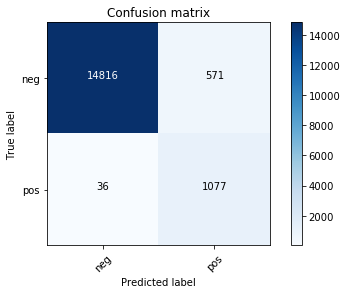

TypeError: 'KerasClassifier' object is not callable

In [29]:
#and use helper functions above to show output
#visualization
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.utils import plot_model
#visualize best model
model=grid
n_classes = 2
model_name = 'dense'
plot_confusion_matrix(confusion_matrix(model.predict(X_test), y_test), ['neg', 'pos'])


Train on 11054 samples, validate on 5446 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


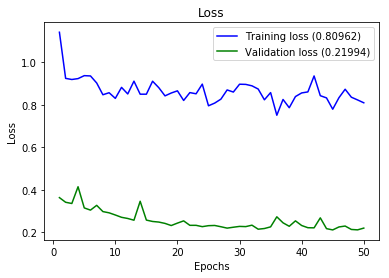

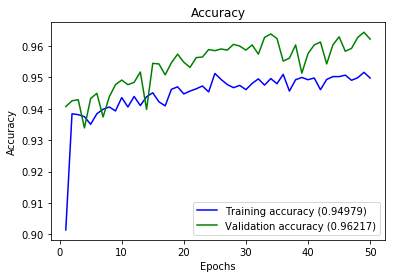

ValueError: unsupported format character 'p' (0x70) at index 8

In [33]:
best = construct_model( layers=model.best_params_['layers'],
              activation=model.best_params_['activation'],
              b_init=model.best_params_['b_init'],
              k_init=model.best_params_['k_init'],
              dropout=model.best_params_['dropout'],
              a_dropout=model.best_params_['a_dropout'],
              optimizer=model.best_params_['optimizer'],
              metrics=model.best_params_['metrics'] )
plot_history(best.fit(X_test, y_test, validation_split=0.33, epochs=50, batch_size=10, verbose=10))
